In [127]:
## Imports
import pandas as pd
import numpy as np
import math
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

In [128]:
## Helper functions
def reversal_node(df_row, current_node):
    if df_row['to'] == current_node:
        df_row['from'], df_row['to'] = df_row['to'],df_row['from']
    return df_row

def get_all_edges(closed, parent, end_node, edges_list):
    edges = []
    for index, row in closed.iterrows():
        edge_ = edges_list.loc[((edges_list['from']==row['node'])&(edges_list['to']==parent[row['node']]))|((edges_list['from']==parent[row['node']])&(edges_list['to']==row['node']))]
        if not edge_.empty:
            edges.append((parent[row['node']], row['node'], edge_.iloc[0]['weights']))
    weight_goal = edges_list.loc[(edges_list['from']==parent[end_node])&(edges_list['to']==end_node)]
    edges.append((parent[end_node], end_node,weight_goal.iloc[0]['weights']))
    return edges

def print_graph_from(path, shortest_path):
    G = nx.Graph()
    G.add_weighted_edges_from(path)
    color = ['r' if e in shortest_path else 'b' for e in G.edges()]
    pos = graphviz_layout(G, prog="dot")
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, edge_color = color)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()

def get_path_to_goal(parent, end_node):
    current_node = end_node
    path_to_goal = []
    while current_node != 'Parent':
        path_to_goal.append((parent[current_node], current_node))
        current_node = parent[current_node]
    return path_to_goal[:-1]

In [180]:
def greedy_best_first_search(edges, straight_dist, start_node, end_node):
    open_structure = pd.DataFrame([[start_node, straight_dist[start_node]]], columns=['node', 'estimated_cost'])
    closed_structure = pd.DataFrame(columns=['node','estimated_cost'])
    success = False
    parent = { start_node: 'Parent'}
    cost_from_parent = { start_node: 0 }
    while not open_structure.empty:
        current_node_data = open_structure.iloc[0]
        current_node, estimated_cost = current_node_data['node'], current_node_data['estimated_cost']
        open_structure = open_structure.iloc[1:]
        if end_node == current_node:
            success = True
            break
        closed_structure = closed_structure.append(current_node_data)
        closed_structure = closed_structure.reset_index(drop=True)
        next_edges = edges.loc[(edges['from'] == current_node)|(edges['to'] == current_node)]
        next_edges = next_edges.apply(lambda row: reversal_node(row, current_node), axis=1)
        for index, row  in next_edges.iterrows():
            closed_node = closed_structure.loc[(closed_structure['node']==row['to'])]
            if closed_node.empty:
                open_node = open_structure.loc[(open_structure['node']==row['to'])]
                if open_node.empty:
                    open_structure = open_structure.append(pd.DataFrame([[row['to'], straight_dist[row['to']]]], columns=['node', 'estimated_cost']))
                    parent[row['to']] = row['from']
                    cost_from_parent[row['to']] = cost_from_parent[row['from']] + row['weights']
        open_structure = open_structure.sort_values(by=['estimated_cost']).reset_index(drop=True)
    return { "meta": "Greedy Best First Search", "success": success , "path": closed_structure, "final_open": open_structure, "current_node": current_node, "parent": parent, "cost_from_parent":cost_from_parent }

In [181]:
def hill_climbing(edges, straight_dist, start_node, end_node):
    open_structure = pd.DataFrame([[start_node, straight_dist[start_node]]], columns=['node', 'estimated_cost'])
    closed_structure = pd.DataFrame(columns=['node','estimated_cost'])
    success = False
    parent = { start_node: 'Parent'}
    cost_from_parent = { start_node: 0 }
    previous_cost = math.inf
    while not open_structure.empty:
        current_node_data = open_structure.iloc[0]
        current_node, estimated_cost = current_node_data['node'], current_node_data['estimated_cost']
        open_structure = open_structure.iloc[1:]
        if estimated_cost < previous_cost:
            if end_node == current_node:
                success = True
                break
            closed_structure = closed_structure.append(current_node_data)
            closed_structure = closed_structure.reset_index(drop=True)
            next_edges = edges.loc[(edges['from'] == current_node)|(edges['to'] == current_node)]
            next_edges = next_edges.apply(lambda row: reversal_node(row, current_node), axis=1)
            for index, row  in next_edges.iterrows():
                open_node = open_structure.loc[(open_structure['node']==row['to'])]
                if open_node.empty:
                    open_structure = open_structure.append(pd.DataFrame([[row['to'], straight_dist[row['to']]]], columns=['node', 'estimated_cost']))
                    parent[row['to']] = row['from']
                    cost_from_parent[row['to']] = cost_from_parent[row['from']] + row['weights']
            open_structure = open_structure.sort_values(by=['estimated_cost']).reset_index(drop=True)
            previous_cost = estimated_cost
        else:
            success = False
            return {"meta": "Hill Climbing", "success": success}
    return {"meta": "Hill Climbing", "success": success, "path": closed_structure, "parent": parent, "cost_from_parent": cost_from_parent, "final_open": open_structure, "total_cost": cost_from_parent[end_node]}
#     return { "success": success , "expanded_node": closed_structure, "current_open": open_structure, "current_node": current_node, "parent": parent}

In [182]:
def a_search(edges, straight_dist, start_node, end_node):
    open_structure = pd.DataFrame([[start_node, straight_dist[start_node]]],columns=['node','estimated_cost'])
    closed_structure = pd.DataFrame(columns=['node', 'estimated_cost'])
    parent = { start_node: 'Parent' }
    cost_from_parent = { start_node: 0 }
    success = False
    
    while not open_structure.empty:
        current_node_data = open_structure.iloc[0]
        current_node, estimated_cost = current_node_data['node'], current_node_data['estimated_cost']
        open_structure = open_structure.iloc[1:]
        
        if current_node == end_node:
            success = True
            break
            
        closed_structure = closed_structure.append(current_node_data)
        closed_structure = closed_structure.reset_index(drop=True)
        
        next_edges = edges.loc[(edges['from']==current_node) |(edges['to']==current_node)]
        next_edges = next_edges.apply(lambda row: reversal_node(row, current_node), axis=1)
        
        for index, row in next_edges.iterrows():
            flag=1
            cost_from_parent_to = cost_from_parent[row['from']]+row['weights']
            estimated_cost = cost_from_parent_to + straight_dist[row['to']]
            closed_node = closed_structure.loc[(closed_structure['node']==row['to'])]
            if not closed_node.empty:
                closed_node = closed_node.iloc[0]
                if closed_node['estimated_cost'] > estimated_cost:
                    closed_structure.drop(closed_structure[closed_structure['node']==row['to']].index, inplace=True)
                else:
                    flag=0
            open_node = open_structure.loc[(open_structure['node']==row['to'])]
            if (not open_node.empty) and flag:
                open_node = open_node.iloc[0]
                if open_node['estimated_cost'] > estimated_cost:
                    parent[row['to']] = row['from']
                    cost_from_parent[row['to']] = cost_from_parent_to
                    open_structure.loc[(open_structure['node']==row['to']),'estimated_cost'] = estimated_cost
            elif flag:
                parent[row['to']] = row['from']
                cost_from_parent[row['to']] = cost_from_parent_to
                open_structure = open_structure.append(pd.DataFrame([[row['to'], estimated_cost]], columns=['node', 'estimated_cost']))
        open_structure = open_structure.sort_values(by=['estimated_cost']).reset_index(drop=True)
    return {"meta": "A* Search", "success":success, "path": closed_structure, "parent": parent, "cost_from_parent": cost_from_parent, "final_open": open_structure, "total_cost": cost_from_parent[end_node]}

In [184]:
def print_result(results, start_node, end_node, edges, straight_dist):
    for result in results:
        print("#################", result['meta'], "#################")
        if(result['success']):
            print("==== Traversed Path ====")
            print(result['path'])
            print("========== Total Cost (Shortest Path)=============")
            shortest_path = get_path_to_goal(result['parent'], end_node)
            print("Path -> Start-Goal: {}\nCost: {}".format(shortest_path,result["cost_from_parent"]['R']))
            print("=======OPEN=========")
            print(result['final_open'])
            path = get_all_edges(result['path'], result['parent'], end_node, edges)
            print_graph(path, shortest_path)
        else:
            print("############### Traversal Failed! ###############\n")

################# A* Search #################
==== Traversed Path ====
  node estimated_cost
0    A            240
1    C            246
2    I            248
3    M            248
4    D            252
5    N            255
6    B            259
7    L            260
8    O            270
========== Total Cost (Shortest Path)=============
Path -> Start-Goal: [('O', 'R'), ('M', 'O'), ('I', 'M'), ('C', 'I'), ('A', 'C')]
Cost: 270
=======OPEN=========
  node  estimated_cost
1    E             274
2    K             278
3    P             284
4    F             309
5    H             331
6    J             361


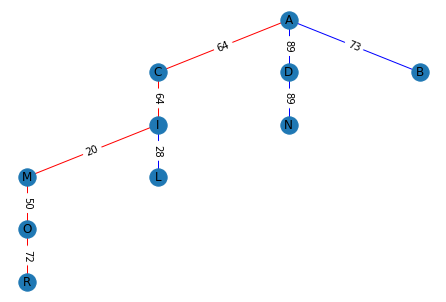

################# Hill Climbing #################
############### Traversal Failed! ###############

################# Greedy Best First Search #################
==== Traversed Path ====
  node estimated_cost
0    A            240
1    D            163
2    N             77
3    J            130
4    Q             65
========== Total Cost (Shortest Path)=============
Path -> Start-Goal: [('Q', 'R'), ('J', 'Q'), ('N', 'J'), ('D', 'N'), ('A', 'D')]
Cost: 376
=======OPEN=========
  node  estimated_cost
1    F             150
2    G             165
3    E             170
4    C             182
5    B             186


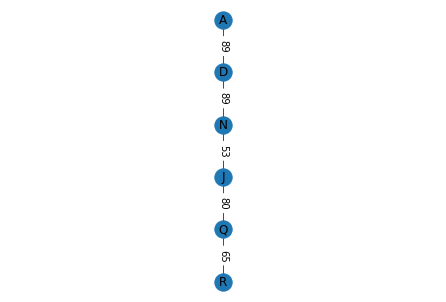

In [185]:
edges = pd.read_csv('edge_list.csv')
straight_dist = pd.read_csv('straight_line.csv',header=None,index_col=0,squeeze=True).to_dict()
start_node, end_node = 'A','R'
result = (a_search(edges, straight_dist, start_node, end_node),
          hill_climbing(edges, straight_dist, start_node, end_node),
          greedy_best_first_search(edges, straight_dist, start_node, end_node))
  
print_result(result, start_node, end_node, edges, straight_dist)

################# A* Search #################
==== Traversed Path ====
  node estimated_cost
0    P             65
========== Total Cost (Shortest Path)=============
Path -> Start-Goal: [('P', 'R')]
Cost: 65


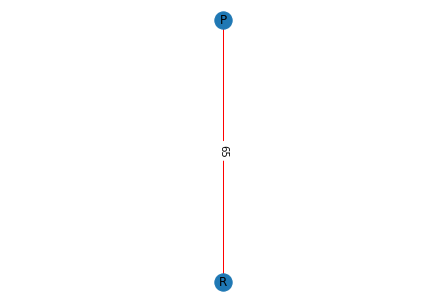

################# Hill Climbing #################
==== Traversed Path ====
  node estimated_cost
0    P             65
========== Total Cost (Shortest Path)=============
Path -> Start-Goal: [('P', 'R')]
Cost: 65


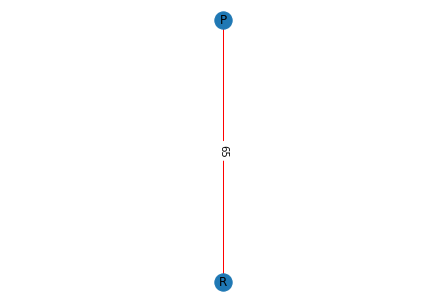

################# Greedy Best First Search #################
==== Traversed Path ====
  node estimated_cost
0    P             65
========== Total Cost (Shortest Path)=============
Path -> Start-Goal: [('P', 'R')]
Cost: 65


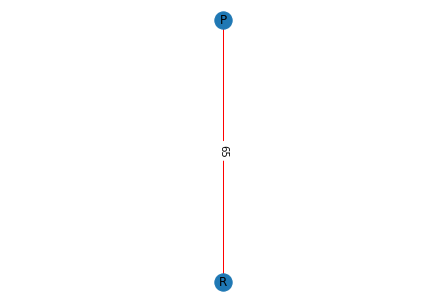

In [177]:
start_node, end_node = 'P','R'
result = (a_search(edges, straight_dist, start_node, end_node),
          hill_climbing(edges, straight_dist, start_node, end_node),
          greedy_best_first_search(edges, straight_dist, start_node, end_node))
print_result(result, start_node, end_node, edges, straight_dist)
